In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse
import numpy as np

import utils2 as utils


# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True, diff_order=1)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(covars_nodiff, should_diff=False)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(covars_diff_yoy,should_diff=True, diff_order=12)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(pd.Timestamp("2016-01-01"))

# Reconvert to DataFrame since statsmodels does not support TimeSeries objects
train = train_ts_scaled.pd_dataframe()
validation = val_ts_scaled.pd_dataframe()
history = pd.concat([train, validation])

# AR Model

<Axes: xlabel='DATE'>

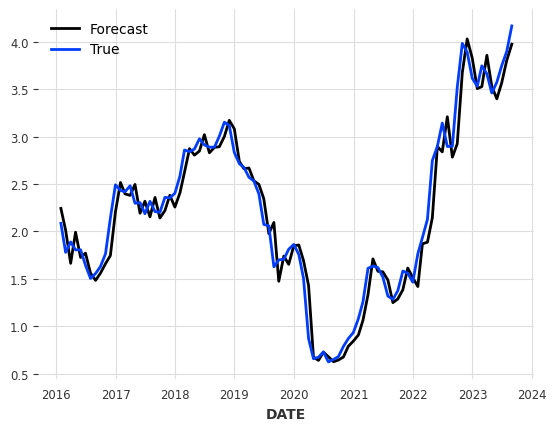

In [2]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Compute the optimal lag order on the training set
sel = ar_select_order(train, 12, old_names=False, glob=True)


# For each time step in the validation set, fit a new model on the history so far and predict the next step
forecasts = pd.DataFrame()
for t in validation.index:

     # Get the history up to the previous month
    hist_t = history[:t - pd.offsets.MonthEnd()]
    # print(hist_t.iloc[-1])

    # Fit the model with data up to the previous month using the optimal lag order
    model = AutoReg(hist_t, lags=sel.ar_lags, old_names=False)
    model_fit = model.fit(cov_type="HC0")

    # Forecast for t + 1
    model_fit = model_fit.append(validation[t:t])
    y_pred = model_fit.get_prediction(start=-1)
    y_pred_unscaled = utils.unscale_series(TimeSeries.from_dataframe(y_pred.summary_frame(), value_cols=["mean"]), pipeline, ts_scaled)
    y_pred_unscaled = y_pred_unscaled.pd_dataframe().rename(columns={"US_TB_YIELD_10YRS": "mean"})
    
    # print(y_pred.summary_frame())



    # Append the forecast to the list of forecasts
    forecasts = pd.concat([forecasts, y_pred_unscaled])

# Revert the scaling
fore_unscaled = TimeSeries.from_dataframe(forecasts, value_cols=["mean"])

# Plot the forecast
fore_unscaled.plot(label="Forecast")
ts.drop_before(pd.Timestamp("2016-01-01")).plot(label="True")

In [3]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:      US_TB_YIELD_10YRS   No. Observations:                  523
Model:             Restr. AutoReg(12)   Log Likelihood                -650.336
Method:               Conditional MLE   S.D. of innovations              0.864
Date:                Sun, 05 Jan 2025   AIC                           1312.673
Time:                        15:33:02   BIC                           1338.091
Sample:                    02-28-1981   HQIC                          1322.638
                         - 08-31-2023                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0101      0.038     -0.265      0.791      -0.085       0.065
US_TB_YIELD_10YRS.L1      0.3248      0.069      4.733      0.000       0.190       0.459
US_TB_YIELD_10YRS.L2     -0.1407      0.060     -2.351      0.019      -0.258      -0.023
US_TB_YIELD_10YRS.L11     0.1051      0.069      1.524      0.128      -0.030       0.240
US_TB_YIELD_10YRS.L12    -0.1222      0.064     -1.898      0.058      -0.248       0.004
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1345           -0.3302j            1.1816           -0.4549
AR.2            -1.1345           +0.3302j            1.1816            0.4549
AR.3            -0.7782           -0.8782j            1.1734           -0.3654
AR.4            -0.7782           +0.8782j            1.1734            0.3654
AR.5            -0.2033           -1.1434j            1.1614           -0.2780
AR.6            -0.2033           +1.1434j            1.1614            0.2780
AR.7             0.3988           -1.0922j            1.1628           -0.1943
AR.8             0.3988           +1.0922j            1.1628            0.1943
AR.9             0.9099           -0.7869j            1.2030           -0.1135
AR.10            0.9099           +0.7869j            1.2030            0.1135
AR.11            1.2373           -0.2862j            1.2700           -0.0362
AR.12            1.2373           +0.2862j            1.2700            0.0362
------------------------------------------------------------------------------

Parameters and standard errors were estimated using a different dataset and were then applied to this dataset.
"""

In [4]:
# Compute the error metrics
print(f"MAPE: {mape(val_ts, fore_unscaled)}")
print(f"RMSE: {rmse(val_ts, fore_unscaled)}")
print(f"R2: {r2_score(val_ts, fore_unscaled)}")

MAPE: 7.349459790629732
RMSE: 0.19062248752552483
R2: 0.9533422271706352


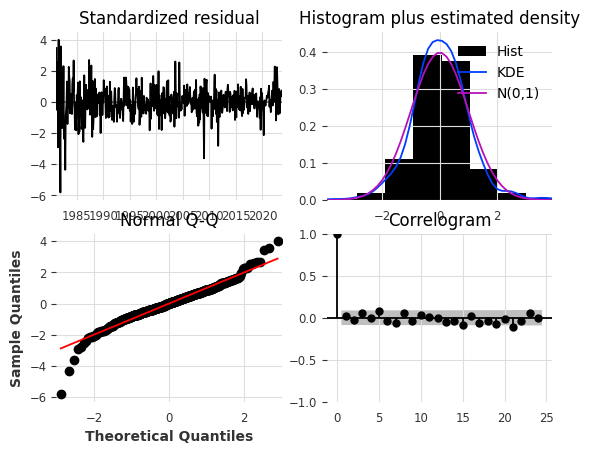

In [5]:
fig = model_fit.plot_diagnostics(lags=24)